In [ ]:
import cv2
import numpy as np
import glob as gl
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  classification_report
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

In [74]:
# 1.Path to images
path_circles = gl.glob("./1_circle/*.png")
path_squares = gl.glob("./2_square/*.png")
path_star = gl.glob("./3_star/*.png")
path_triangles = gl.glob("./4_triangle/*.png")

print(len(path_circles))
print(len(path_squares))
print(len(path_star))
print(len(path_triangles))


219
299
316
397


In [75]:
#2. Read images
images_circles = [cv2.imread(img_path) for img_path in path_circles]
images_triangles = [cv2.imread(img_path) for img_path in path_triangles]
images_squares = [cv2.imread(img_path) for img_path in path_squares]
images_rectangles = [cv2.imread(img_path) for img_path in path_triangles]

In [76]:
def preprocess_images(images, label_name):
    features = []
    labels = []
    
    for img in images:
        # Converte para grayscale se necessário
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
        
        # Binariza (sem inverter)
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        
        # Calcula momentos de Hu
        moments = cv2.moments(binary)
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Normaliza com logaritmo
        hu_moments = [-1 * np.sign(h) * np.log10(abs(h)) if h != 0 else 0 for h in hu_moments]
        
        features.append(hu_moments)
        labels.append(label_name)
    
    return features, labels




In [77]:
# Process each category of images

hu_circles =[preprocess_images(image, "circle") for image in images_circles]
hu_triangles = [preprocess_images(image, "triangle") for image in images_triangles]
hu_squares = [preprocess_images(image, "square") for image in images_squares]
hu_rectangles = [preprocess_images(image, "rectangle") for image in images_rectangles]

# 4. Combine all processed images and labels
all_hu_moments = hu_circles + hu_triangles + hu_squares + hu_rectangles

# Randomly sample a subset of Hu moments for analysis
random.seed(42)  # Para reprodutibilidade
random.shuffle(all_hu_moments)


In [78]:
# Supondo all_hu_moments = [(hu_moments, label), ...]
training_data = all_hu_moments[:600]
testing_data = all_hu_moments[600:]

# Garantindo que X_train seja 2D (600,7)
X_train = np.array([np.ravel(data[0]) for data in training_data])  # ravel transforma em 1D
Y_train = np.array([data[1] for data in training_data])

X_test = np.array([np.ravel(data[0]) for data in testing_data])
Y_test = np.array([data[1] for data in testing_data])

print(X_train.shape)  # deve ser (600, 7)
print(Y_train.shape)  # deve ser (600,)



(600, 1400)
(600, 200)


In [83]:
# 7. Treinar o classificador KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
stand =StandardScaler()
X_train_scaled = stand.fit_transform(X_train)
knn.fit(X_train_scaled, Y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [84]:
X_test_scaled = stand.transform(X_test)
Y_pred = knn.predict(X_test_scaled)

In [95]:
# Garantir que os labels sejam 1D
Y_test_1d = np.ravel(Y_test)
Y_pred_1d = np.ravel(Y_pred)

print(Y_test_1d.shape)
print(Y_pred_1d.shape)

(142400,)
(142400,)


In [94]:
print(classification_report(Y_test_1d, Y_pred_1d))

              precision    recall  f1-score   support

      circle       0.98      0.94      0.96     24600
   rectangle       0.39      0.54      0.45     40800
      square       0.96      0.96      0.96     31800
    triangle       0.37      0.25      0.30     45200

    accuracy                           0.61    142400
   macro avg       0.67      0.67      0.67    142400
weighted avg       0.61      0.61      0.60    142400



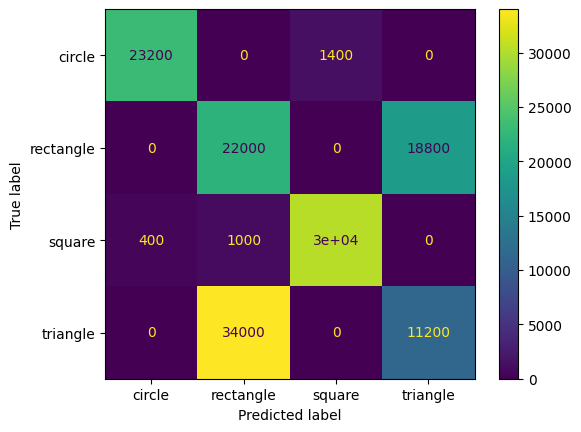